In [151]:
import seaborn as sns

In [152]:
import numpy as np
from matplotlib import pyplot as plt

In [153]:
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [154]:
plt.rc('font', family='Arial')
sns.set_context("paper")
plt.rcParams.update({
    "text.usetex": True,
     # "font.family": "Helvetica"
})

# F1C Bar PLot for Chemeric Read compare

In [174]:
type_names = ["Dorado with Trim",  "Dorado w/o Trim",  "DC"] 

data = {
     type_names[0]: [107266, 6228],
    type_names[1] : [107304, 6228],
     type_names[2]: [9844, 4664],
}

data_with_validated = {
        "value":  list(chain.from_iterable([ [data[t][0] - data[t][1],data[t][1] ]    for t in type_names  ])),
        "data type": list(chain.from_iterable([ [i] * 2    for i in type_names])),
        "type": ["Unvalidated", "Validated"] * len(type_names)
        
    }

In [175]:
data_df = pd.DataFrame(
    data_with_validated
)

In [176]:
data_df

,value,data type,type
0,101038,Dorado with Trim,Unvalidated
1,6228,Dorado with Trim,Validated
2,101076,Dorado w/o Trim,Unvalidated
3,6228,Dorado w/o Trim,Validated
4,5180,DC,Unvalidated
5,4664,DC,Validated


In [177]:
# % colors
# \definecolor{mylightred}{RGB}{255,200,200}
# \definecolor{mylightblue}{RGB}{172,188,63}
# \definecolor{mylightgreen}{RGB}{150,220,150}

c1 = [ i/255 for i in (255,200,200)]

c2 =  [i/255 for i in (150,220,150)]

c3 = [i/255 for i in  (172,188,63)]

In [178]:
data_df.groupby("data type")['value'].sum().reset_index()

,data type,value
0,DC,9844
1,Dorado w/o Trim,107304
2,Dorado with Trim,107266


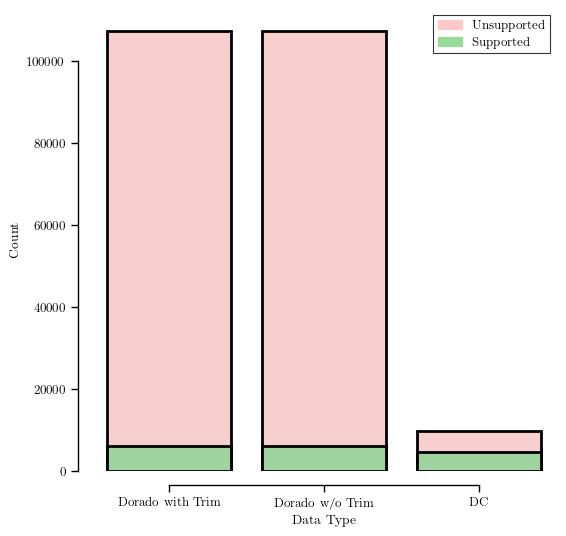

In [197]:
plt.figure(figsize=(6, 6))

bar1 = sns.barplot(data=data_df.groupby("data type")['value'].sum().reset_index(), x="data type", y="value", order=type_names,  color=c1, edgecolor="k", linewidth=2)
bar2 =  sns.barplot(data=data_df.query("type == 'Validated'") , x="data type", y="value", order=type_names,  estimator=sum, color=c2, edgecolor="k" ,  linewidth=2)

# add legend
top_bar = mpatches.Patch(color=c1, label='Unsupported')
bottom_bar = mpatches.Patch(color=c2, label='Supported')
plt.legend(handles=[top_bar, bottom_bar], 
           edgecolor='k',
           fancybox=False)
sns.despine(offset=10, trim=True)

plt.ylabel("Count")
plt.xlabel("Data  Type")

plt.savefig(f'bar_plot_chemeric_read_cmp.pdf',  
        bbox_inches='tight',  
        dpi=300  
        )

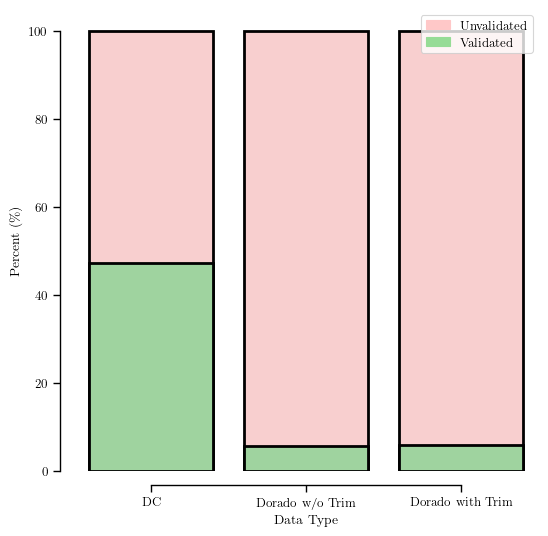

In [120]:
plt.figure(figsize=(6, 6))
total = data_df.groupby("data type")['value'].sum().reset_index()
validated = data_df.query("type == 'Validated'").groupby("data type")['value'].sum().reset_index()
validated['value' ]  = [i / j * 100 for i,j in zip(validated['value'], total['value'])]
total['value'] = [i / j * 100 for i,j in zip(total['value'], total['value'])]

bar1 = sns.barplot(x="data type",  y="value", data=total, color=c1,  edgecolor="k", linewidth=2)

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="data type", y="value", data=validated, color=c2,  edgecolor="k", linewidth=2)

# add legend
top_bar = mpatches.Patch(color=c1, label='Unvalidated')
bottom_bar = mpatches.Patch(color=c2, label='Validated')
plt.legend(handles=[top_bar, bottom_bar])
sns.despine(offset=10, trim=True)

plt.ylabel("Percent ($\%$)")
plt.xlabel("Data  Type")

plt.savefig(f'bar_plot_chemeric_read_cmp_same_height.pdf',  
        bbox_inches='tight',  
        dpi=300  
        )

In [31]:
data_with_validated

{'value': [101038, 6228, 5180, 4664, 101076, 6228],
 'data type': ['Dorado with Trim',
  'Dorado with Trim',
  'DC',
  'DC',
  'Dorado w/o Trim',
  'Dorado w/o Trim'],
 'type': ['Unvalidated',
  'Validated',
  'Unvalidated',
  'Validated',
  'Unvalidated',
  'Validated']}

In [ ]:
# Figure 1D, E, F: BLAT, quality and PolyA motif for false positive chimeric artifacts.


# F1D BLAT for internal prediction FP (Dorado chemeric reads - DC chemeric reads)

In [124]:
import json

In [125]:
# load data 
plot_data = json.load(open("data/internal_prediction_seq_blat_top1_indentities.json"))

In [129]:
len(plot_data)

98807

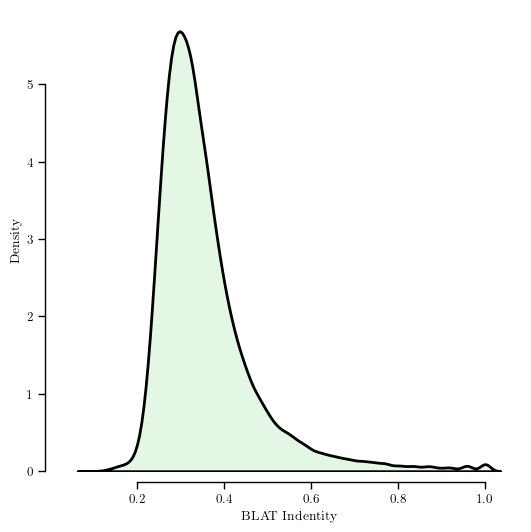

In [144]:
plt.figure(figsize=(6, 6))
sns.kdeplot(data=plot_data, fill=True, color=c3, edgecolor="k", linewidth=2)
sns.despine(offset=8, trim=True)
plt.xlabel("BLAT Indentity")
# plt.ylabel("Density")
plt.savefig(f'blat_for_fp_internal_prediction_cmp_with_dorado.pdf',  
        bbox_inches='tight',  
        dpi=300  
        )

# F1E Base Quals for internal prediction FP (Dorado chemeric reads - DC chemeric reads)

In [183]:
import json

In [186]:
def plot_qual(file_path):
    from needletail import parse_fastx_file
    quals = []
    for record in parse_fastx_file(file_path):
        current_quals = [ord(i) - 33 for i in list(record.qual)]
        quals.append(sum(current_quals)/len(current_quals))
    return quals

In [189]:
# load data 
plot_data = json.load(open("data/internal_prediction_seq_base_quals.json"))

In [190]:
plot_data = [ i - 33 for i in plot_data]

In [188]:
# load data 
plot_qual_left_seq_data = plot_qual("./data/fp_dorado_heyna_vcap002.fq.gz")

In [191]:
len(plot_qual_left_seq_data)

88164

In [192]:
len(plot_data)

146580

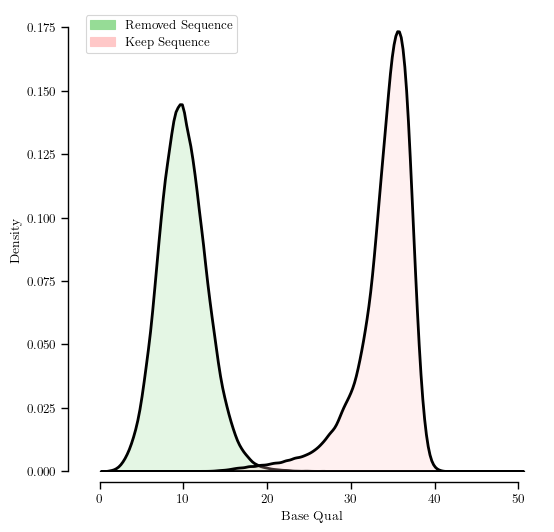

In [202]:
plt.figure(figsize=(6, 6))
sns.kdeplot(data=plot_data, fill=True, color=c2, edgecolor="k", linewidth=2)
sns.kdeplot(data=plot_qual_left_seq_data, fill=True, color=c1, edgecolor="k", linewidth=2)

left_bar = mpatches.Patch(color=c2, label='Removed Sequence')
right_bar = mpatches.Patch(color=c1, label='Keep Sequence')
plt.legend(handles=[left_bar, right_bar], loc="upper left")

sns.despine(offset=8, trim=True)
plt.xlabel("Base Qual")
plt.ylabel("Density")
plt.savefig(f'base_quals_for_fp_internal_prediction_cmp_with_dorado.pdf',  
        bbox_inches='tight',  
        dpi=300  
        )